<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-jet-images" data-toc-modified-id="Generate-jet-images-1">Generate jet images</a></span><ul class="toc-item"><li><span><a href="#plot-some-jets" data-toc-modified-id="plot-some-jets-1.1">plot some jets</a></span></li></ul></li><li><span><a href="#Training-neural-networks" data-toc-modified-id="Training-neural-networks-2">Training neural networks</a></span><ul class="toc-item"><li><span><a href="#run-on-Colab" data-toc-modified-id="run-on-Colab-2.1">run on Colab</a></span></li><li><span><a href="#analyze" data-toc-modified-id="analyze-2.2">analyze</a></span><ul class="toc-item"><li><span><a href="#Check-effect-of-pixel-normalization" data-toc-modified-id="Check-effect-of-pixel-normalization-2.2.1">Check effect of pixel normalization</a></span></li><li><span><a href="#Compare-to-high-pT-jets" data-toc-modified-id="Compare-to-high-pT-jets-2.2.2">Compare to high pT jets</a></span></li></ul></li></ul></li></ul></div>

See details and walkthrough for this notebook at https://ilmonteux.github.io/2018/10/15/jet-tagging-cnn.html

## Load libraries and functions

In [170]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from tabulate import tabulate



# find pythia path so you can import it
pythia_path = '/Users/mghasemi/Desktop/Code/Code/Generators/pythia8310/'
cfg = open(pythia_path+"examples/Makefile.inc")
lib = pythia_path+"lib"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break
sys.path.insert(0, lib)
import pythia8

# define general variables
etaedges = np.arange(-3,3+0.01,0.12)
phiedges = np.arange(-np.pi*4/3,np.pi*4/3+0.01,np.pi/18.)
cmap = plt.get_cmap('gray_r')
PTCUT = 50.
nevents = 5000
outdir = 'images_out/'

"""
Write two Madgraph cards for production of up and anit-up events.
Apply generator-level cut on the particle momenta given by PTRANGE,
allowing for a tolerance delta. If argument extra is specified, 
append it to output directories
"""
def write_mg_cards(PTRANGE, delta=10, nevents=200000, extra=''):
    with open('generate_up.mg5','w') as f:
        f.write("""
    generate p p > u g
    output jets_up{3}
    launch
    madspin=none
    done
    set nevents {2}
    set pt_min_pdg {{ 2: {0} }}
    set pt_max_pdg {{ 2: {1} }}
                done    
    """.format(PTRANGE[0]-delta, PTRANGE[1]+delta, nevents, extra))

    with open('generate_upbar.mg5','w') as f:
        f.write("""
    generate p p > u~ g
    output jets_qcd{3}
    launch
    done
    set nevents {2}
    set ptj {0}
    set ptjmax {1}
    done    
    """.format(PTRANGE[0]-delta, PTRANGE[1]+delta, nevents, extra))


"""
If a jet center is close to either 0 or 2*pi, its constituents could be on the other side
of the periodicity line. This takes care of this problem by remapping phi to be either
above 2*pi or below zero.
"""
def extend_jet_phi(phi, jet_phi):
    if abs(jet_phi + np.pi)<1.: # phi close to -pi
        return phi-2*np.pi*int(abs(phi-np.pi) <1-abs(jet_phi + np.pi))
    elif abs(jet_phi - np.pi)<1.: # phi close to pi
        return phi+2*np.pi*int(abs(-phi-np.pi) < 1-abs(jet_phi - np.pi)) 
    else: 
        return phi


""" 
Leading jet and constituents are passed as pythia vec4 objects.
Restricts image grid to within a DeltaR=1.2 range around jet center.
Returns pT-weighted histogram, and tuple with histogram grid.
"""
def make_image_leading_jet(leading_jet, leading_jet_constituents, charge):
    jet_phi = leading_jet.phi()
    jet_eta = leading_jet.eta()
    ### redefine grid to only be Delta R=1.2 around jet center
    yedges = [phi for phi in phiedges if abs(phi-jet_phi)<=1.2+(phiedges[1]-phiedges[0])]
    xedges = [eta for eta in etaedges if abs(eta-jet_eta)<=1.2+(etaedges[1]-etaedges[0])]
    
    jet_constituents = np.array([ [c.pT(), c.eta(), extend_jet_phi(c.phi(), jet_phi) ] for c in leading_jet_constituents ])    
    jet_charge = np.array([[c] for c in charge])    
    jet_constituents = np.concatenate((jet_constituents, jet_charge), axis = 1)     
    

    #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2], bins=(xedges,yedges), weights=jet_constituents[:,0])
    histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2], bins=(xedges,yedges), weights=jet_constituents[:,3])    
    #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2], bins=(xedges,yedges), weights=jet_constituents[:,3], density=True)    
    #print('jet_constituents:\n', jet_constituents)    
    
    ### transpose to have eta=x, phi=y
    #print(histo.T.shape)

    return histo.T, (xedges, yedges)
    

""" 
Jets are passed as pythia vec4 objects
Returns list of pT-weighted histogram, and tuple with histogram grids, covering full (eta,phi) ranges
"""    
def make_image_event(all_jets, all_constituents, charge):    
    out=[]
    for i in range(len(all_jets)):
        jet_phi = all_jets[i].phi()
        
        jet_constituents = np.array([ [c.pT(), c.eta(), extend_jet_phi(c.phi(), jet_phi) ] for c in all_constituents[i] ])    
        jet_charge = np.array([[c] for c in charge[i]])        
        jet_constituents = np.concatenate((jet_constituents, jet_charge), axis=1)
        #print('jet_constituents:\n', jet_constituents)        

        #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2],bins=(etaedges,phiedges),weights=jet_constituents[:,0])
        histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2],bins=(etaedges,phiedges),weights=jet_constituents[:,3])
        #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2],bins=(etaedges,phiedges),weights=jet_constituents[:,3], density=True)
    
        ### append to output (transpose to have eta=x, phi=y)
        out.append(histo.T)
    
    return out, (xedges, yedges)


"""
Take an LHE file, run pythia on it, outputs images.
For each event, cluster jets, check if the two highest pT jets are in PTRANGE and PTRANGE2,
and make 2D histograms of the leading jet and of the whole event.
If plot_first_few=True, plot both images for first 5 events
"""
def run_pythia_get_images(lhe_file_name, nevents, kappa, plot_first_few=True):       
    # unzip LHE file if it is zipped
    if lhe_file_name.endswith('gz') and not os.path.isfile(lhe_file_name.split('.gz')[0]): 
        os.system('gunzip < {} > {}'.format(lhe_file_name, lhe_file_name.split('.gz')[0]))
    lhe_file_name = lhe_file_name.split('.gz')[0]
    if not os.path.isfile(lhe_file_name): raise Exception('no LHE file')
        
    pythia = pythia8.Pythia()
    ### read LHE input file
    pythia.readString("Beams:frameType = 4")
    pythia.readString("Beams:LHEF = "+lhe_file_name)

    pythia.init()
    ### define jet parameters: antikt, R, pT_min, Eta_max
    slowJet = pythia8.SlowJet(-1, 0.2, 10, 2.5)

    # outputs: lists of leading jet and full detector images, and (pT, eta, phi) of each jet
    leading_jet_images, all_jet_images = [], []
    jetpep=[]
    njet = []    
    VARS = ['subjetpT'+str(i) for i in range(10)] + \
       ['subjeteta'+str(i) for i in range(10)] + \
       ['subjetphi'+str(i) for i in range(10)] + \
       ['subjetcharge'+str(i) for i in range(10)] + \
       ['subjetmt'+str(i) for i in range(10)] + \
       ['Q_'+str(i)+'_kappa' for i in range(1, 5)] + \
       ['charge ratio']
    df = pd.DataFrame(columns=VARS)

    iplot=0
    nEvent = 0
    ### Begin event loop. Generate event. Skip if error or file ended. Print counter
    for iEvent in range(0,nevents):
        if not pythia.next(): continue   
        if(iEvent == 5): break                   
        #if(iEvent != 2): continue

        ### Cluster jets. List first few jets. Excludes neutrinos by default
        slowJet.analyze(pythia.event)        
        #njets = len([j for j in range(0,slowJet.sizeJet()) if slowJet.p(j).pT()> PTCUT])
        njets = len([j for j in range(0,slowJet.sizeJet())])        
        if njets<1: continue 
        njet.append(njets)
        #nEvent+=1
        
        ### all kinematic variables  
        jetpep.append([[slowJet.p(j).pT(), slowJet.p(j).eta(), slowJet.p(j).phi()] for j in range(0, njets)])       # pT, eta, and phi all jets
        jet_list = [ slowJet.p(j) for j in range(0, njets)] # if PTRANGE2[0]<=slowJet.p(j).pT()<=PTRANGE2[1]]       # 4vec all jets
        jet_constituent_list=[ [ pythia.event[c].p() for c in slowJet.constituents(j)] for j in range(0, njets)]    # 4vec all jet's constituents    
        pT = [[pythia.event[c].p().pT() for c in slowJet.constituents(j)] for j in range(0, njets)]                 # pT of all jet's constituents
        eta = [[pythia.event[c].p().eta() for c in slowJet.constituents(j)] for j in range(0, njets)]               # eta of all jet's constituents
        phi = [[pythia.event[c].p().phi() for c in slowJet.constituents(j)] for j in range(0, njets)]               # phi of all jet's constituents           
        mT = [[pythia.event[c].mT() if pythia.event[c].charge() != 0 else 0 for c in slowJet.constituents(j)] \
             for j in range(njets)]                                                                                 # mT of all jet's constituents
        charge = [[pythia.event[c].charge() for c in slowJet.constituents(j)] for j in range(0, njets)]             # charge of all jet's constituents
        total_charge = sum([charges for sublist in charge for charges in sublist])                                  # charge of jet        
        pT_jet = [slowJet.p(j).pT() for j in range(0, njets)]                                                       # pT of jets
        eta_jet = [slowJet.p(j).eta() for j in range(0, njets)]                                                     # eta of jets
        total_pT = sum([slowJet.p(j).pT() for j in range(0, njets)])                                                # total jet pT        
        
        # list of index with sorted jets based on pT
        flattened_pT_with_indices = [(value, (i, j)) for i, sublist in enumerate(pT) for j, value in enumerate(sublist)]        
        sorted_pT_with_indices = sorted(flattened_pT_with_indices, key=lambda x: x[0], reverse=True)
        sorted_indices = [index for value, index in sorted_pT_with_indices]
        #pT[sorted_indices[0][0]][sorted_indices[0][1]]        

        # Q_1kappa and Q_2kappa variables
        result_Q1 = []
        result_Q2 = []        
        for pT_list, charge_list, pT_j in zip(pT, charge, pT_jet):            
            sublist_result_Q1 = [(pT_i/pT_j)**kappa * charge_i for pT_i, charge_i in zip(pT_list, charge_list)]            
            sublist_result_Q2 = [(pT_i/pT_j)**kappa * charge_i for pT_i, charge_i in zip(pT_list, charge_list) if (pT_i/pT_j) > 0.1]
            result_Q1.append(sublist_result_Q1)    
            result_Q2.append(sublist_result_Q2)            
        Q_1kappa = (sum([item for sublist in result_Q1 for item in sublist]))        
        Q_2kappa = (sum([item for sublist in result_Q2 for item in sublist]))
        
        # Q_3kappa and Q_4kappa variables
        result_Q3 = []
        result_Q4 = []        
        for eta_list, eta_j in zip(eta, eta_jet):
            eta_diff = [(np.abs(eta_subjet - eta_j)**kappa) for eta_subjet in eta_list]
        delta_eta = sum(eta_diff)
        for pT_list, eta_list, charge_list, eta_j, pT_j in zip(pT, eta, charge, eta_jet, pT_jet) :            
            sublist_result_Q3 = [(np.abs(eta_i-eta_j)**kappa / delta_eta) * charge_i for eta_i, charge_i in zip(eta_list, charge_list)]
            sublist_result_Q4 = [(np.abs(eta_i-eta_j)**kappa / delta_eta) * charge_i for eta_i, charge_i, pT_i in zip(eta_list, charge_list, pT_list) if (pT_i/pT_j) > 0.1]            
            result_Q3.append(sublist_result_Q3)    
            result_Q4.append(sublist_result_Q4)        
        Q_3kappa = (sum([item for sublist in result_Q3 for item in sublist]))        
        Q_4kappa = (sum([item for sublist in result_Q4 for item in sublist]))
        
        # ratio of positive to negative charges
        flattened_charges = [item for sublist in charge for item in sublist]        
        positive_numbers = [num for num in flattened_charges if num > 0]
        negative_numbers = [num for num in flattened_charges if num < 0]            
        charge_ratio = sum(positive_numbers) / abs(sum(negative_numbers)) if sum(negative_numbers) != 0 else float('nan')

        # charged weighted based on mT
        result_Q1 = []        
        for pT_list, charge_list, pT_j in zip(pT, charge, pT_jet):
            
            sublist_result_Q1 = [(pT_i/pT_j)**kappa * charge_i for pT_i, charge_i in zip(pT_list, charge_list)]            
            sublist_result_Q2 = [(pT_i/pT_j)**kappa * charge_i for pT_i, charge_i in zip(pT_list, charge_list) if (pT_i/pT_j) > 0.1]
            result_Q1.append(sublist_result_Q1)    
            result_Q2.append(sublist_result_Q2)            
        Q_1kappa = (sum([item for sublist in result_Q1 for item in sublist]))  
        
        ### flatten the variables and fill the dataframe
        flatten_and_pad = lambda lst, length: [item for sublist in lst for item in sublist] + [float('nan')] * (length - sum(len(sublist) for sublist in lst))
        pT_flat = flatten_and_pad(pT, 10)
        eta_flat = flatten_and_pad(eta, 10)
        phi_flat = flatten_and_pad(phi, 10)
        charge_flat = flatten_and_pad(charge, 10)        
        mT_flat = flatten_and_pad(mT, 10)        
        row_data = pT_flat + eta_flat + phi_flat + charge_flat + mT_flat + \
                  [Q_1kappa, Q_2kappa, Q_3kappa, Q_4kappa] + [charge_ratio]          
        #df.loc[nEvent] = row_data        
        #print(tabulate(df, headers='keys', tablefmt='psql'))

        nEvent+=1
            
        # print important variables
        show = True
        if show:
            print('iEvent:', iEvent)
            #print('njets:', njets)            
            print('jetpep:', jetpep)
            #print('jet_list:', jet_list)
            #print('jet_constituent_list:', jet_constituent_list)
            print('number of leading jets:', len(jet_constituent_list))
            for i in range(njets):
                print('number of leading jet_constituent:', len(jet_constituent_list[i]))            
            print('pT of subjets:', pT)            
            print('eta of subjets:', eta)  
            print('phi of subjets:', phi)            
            print('charge of subjets:', charge)
            print('mT of subjets:', mT)
            print('total charge:', total_charge)
            print('pT jet:', pT_jet)
            print('eta jet:', eta_jet)
            print('total pT:', total_pT)                    
            print('Q_1kappa:', Q_1kappa)
            print('Q_2kappa:', Q_2kappa)
            print('Q_3kappa:', Q_3kappa)
            print('Q_4kappa:', Q_4kappa)

        df.loc[nEvent] = row_data        
        print(tabulate(df, headers='keys', tablefmt='psql'))

        # make pixels with at least one high-pT small R jet in the right range
        if njets<1: continue         
        hh, (xx, yy) = make_image_leading_jet(jet_list[0], jet_constituent_list[0], charge[0])      # pixels for leading jet
        hh1, _ = make_image_event(jet_list, jet_constituent_list, charge)                           # pixles for all jet's constituents
        
        leading_jet_images.append(hh)
        all_jet_images.append(hh1)
        
        if plot_first_few and iplot<2:
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))    
            c1 = ax1.pcolor(xx,yy, hh, cmap=cmap)
            fig.colorbar(c1, ax=ax1)
            c2 = ax2.pcolor(etaedges, phiedges, sum(hh1), cmap=cmap)
            fig.colorbar(c2, ax=ax2)
            for j in jet_list:
                ax2.add_artist(plt.Circle((j.eta(),j.phi()),1, color='r', fill=False) )
            for h in [-np.pi, np.pi]: 
                ax2.axhline(h, ls='--', lw=1, c='white')
            iplot+=1

    #return leading_jet_images, all_jet_images, np.array(jetpep)
    #print("nEvent:", nEvent, '\n')            
    return leading_jet_images, all_jet_images, jetpep, njet

"""
Simply pad an image with zeros up to max_size.
"""
def pad_image(image, max_size = (16,22)):
    size = np.shape(image)
    px, py = (max_size[0]-size[0]), (max_size[1]-size[1])
    #image = np.pad(image, (map(int,((np.floor(px/2.), np.ceil(px/2.)))), map(int,(np.floor(py/2.), np.ceil(py/2.)))), 'constant')    
    image = np.pad(image, ((int(np.floor(px/2.)), int(np.ceil(px/2.))), (int(np.floor(py/2.)), int(np.ceil(py/2.)))), 'constant', constant_values=(0))    
    return image

"""
Normalize picture in [0,multi] range, with integer steps. E.g. multi=255 for 256 steps.
"""
def normalize(histo, multi=255):

    return (histo/np.max(histo)*multi).astype(int)

In [184]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from tabulate import tabulate



# find pythia path so you can import it
pythia_path = '/Users/mghasemi/Desktop/Code/Code/Generators/pythia8310/'
cfg = open(pythia_path+"examples/Makefile.inc")
lib = pythia_path+"lib"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break
sys.path.insert(0, lib)
import pythia8

# define general variables
etaedges = np.arange(-3,3+0.01,0.12)
phiedges = np.arange(-np.pi*4/3,np.pi*4/3+0.01,np.pi/18.)
cmap = plt.get_cmap('gray_r')
PTCUT = 50.
nevents = 5000
outdir = 'images_out/'

"""
Write two Madgraph cards for production of up and anit-up events.
Apply generator-level cut on the particle momenta given by PTRANGE,
allowing for a tolerance delta. If argument extra is specified, 
append it to output directories
"""
def write_mg_cards(PTRANGE, delta=10, nevents=200000, extra=''):
    with open('generate_up.mg5','w') as f:
        f.write("""
    generate p p > u g
    output jets_up{3}
    launch
    madspin=none
    done
    set nevents {2}
    set pt_min_pdg {{ 2: {0} }}
    set pt_max_pdg {{ 2: {1} }}
                done    
    """.format(PTRANGE[0]-delta, PTRANGE[1]+delta, nevents, extra))

    with open('generate_upbar.mg5','w') as f:
        f.write("""
    generate p p > u~ g
    output jets_qcd{3}
    launch
    done
    set nevents {2}
    set ptj {0}
    set ptjmax {1}
    done    
    """.format(PTRANGE[0]-delta, PTRANGE[1]+delta, nevents, extra))


"""
If a jet center is close to either 0 or 2*pi, its constituents could be on the other side
of the periodicity line. This takes care of this problem by remapping phi to be either
above 2*pi or below zero.
"""
def extend_jet_phi(phi, jet_phi):
    if abs(jet_phi + np.pi)<1.: # phi close to -pi
        return phi-2*np.pi*int(abs(phi-np.pi) <1-abs(jet_phi + np.pi))
    elif abs(jet_phi - np.pi)<1.: # phi close to pi
        return phi+2*np.pi*int(abs(-phi-np.pi) < 1-abs(jet_phi - np.pi)) 
    else: 
        return phi


""" 
Leading jet and constituents are passed as pythia vec4 objects.
Restricts image grid to within a DeltaR=1.2 range around jet center.
Returns pT-weighted histogram, and tuple with histogram grid.
"""
def make_image_leading_jet(leading_jet, leading_jet_constituents, charge):
    jet_phi = leading_jet.phi()
    jet_eta = leading_jet.eta()
    ### redefine grid to only be Delta R=1.2 around jet center
    yedges = [phi for phi in phiedges if abs(phi-jet_phi)<=1.2+(phiedges[1]-phiedges[0])]
    xedges = [eta for eta in etaedges if abs(eta-jet_eta)<=1.2+(etaedges[1]-etaedges[0])]
    
    jet_constituents = np.array([ [c.pT(), c.eta(), extend_jet_phi(c.phi(), jet_phi) ] for c in leading_jet_constituents ])    
    jet_charge = np.array([[c] for c in charge])    
    jet_constituents = np.concatenate((jet_constituents, jet_charge), axis = 1)     
    

    #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2], bins=(xedges,yedges), weights=jet_constituents[:,0])
    histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2], bins=(xedges,yedges), weights=jet_constituents[:,3])    
    #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2], bins=(xedges,yedges), weights=jet_constituents[:,3], density=True)    
    #print('jet_constituents:\n', jet_constituents)    
    
    ### transpose to have eta=x, phi=y
    #print(histo.T.shape)

    return histo.T, (xedges, yedges)
    

""" 
Jets are passed as pythia vec4 objects
Returns list of pT-weighted histogram, and tuple with histogram grids, covering full (eta,phi) ranges
"""    
def make_image_event(all_jets, all_constituents, charge):    
    out=[]
    for i in range(len(all_jets)):
        jet_phi = all_jets[i].phi()
        
        jet_constituents = np.array([ [c.pT(), c.eta(), extend_jet_phi(c.phi(), jet_phi) ] for c in all_constituents[i] ])    
        jet_charge = np.array([[c] for c in charge[i]])        
        jet_constituents = np.concatenate((jet_constituents, jet_charge), axis=1)
        #print('jet_constituents:\n', jet_constituents)        

        #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2],bins=(etaedges,phiedges),weights=jet_constituents[:,0])
        histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2],bins=(etaedges,phiedges),weights=jet_constituents[:,3])
        #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2],bins=(etaedges,phiedges),weights=jet_constituents[:,3], density=True)
    
        ### append to output (transpose to have eta=x, phi=y)
        out.append(histo.T)
    
    return out, (xedges, yedges)


"""
Take an LHE file, run pythia on it, outputs images.
For each event, cluster jets, check if the two highest pT jets are in PTRANGE and PTRANGE2,
and make 2D histograms of the leading jet and of the whole event.
If plot_first_few=True, plot both images for first 5 events
"""
def run_pythia_get_images(lhe_file_name, nevents, kappa, plot_first_few=True):       
    # unzip LHE file if it is zipped
    if lhe_file_name.endswith('gz') and not os.path.isfile(lhe_file_name.split('.gz')[0]): 
        os.system('gunzip < {} > {}'.format(lhe_file_name, lhe_file_name.split('.gz')[0]))
    lhe_file_name = lhe_file_name.split('.gz')[0]
    if not os.path.isfile(lhe_file_name): raise Exception('no LHE file')
        
    pythia = pythia8.Pythia()
    ### read LHE input file
    pythia.readString("Beams:frameType = 4")
    pythia.readString("Beams:LHEF = "+lhe_file_name)

    pythia.init()
    ### define jet parameters: antikt, R, pT_min, Eta_max
    slowJet = pythia8.SlowJet(-1, 0.2, 10, 2.5)

    # outputs: lists of leading jet and full detector images, and (pT, eta, phi) of each jet
    leading_jet_images, all_jet_images = [], []
    jetpep=[]
    njet = []    
    VARS = ['subjetpT'+str(i) for i in range(20)] + \
       ['subjeteta'+str(i) for i in range(20)] + \
       ['subjetphi'+str(i) for i in range(20)] + \
       ['subjetcharge'+str(i) for i in range(20)] + \
       ['subjetmt'+str(i) for i in range(20)] + \
       ['Q_'+str(i)+'_kappa' for i in range(1, 5)] + \
       ['charge ratio']
    df = pd.DataFrame(columns=VARS)

    iplot=0
    nEvent = 0
    ### Begin event loop. Generate event. Skip if error or file ended. Print counter
    for iEvent in range(0,nevents):
        if not pythia.next(): continue   
        if(iEvent == 10): break                   
        #if(iEvent != 2): continue

        ### Cluster jets. List first few jets. Excludes neutrinos by default
        slowJet.analyze(pythia.event)        
        #njets = len([j for j in range(0,slowJet.sizeJet()) if slowJet.p(j).pT()> PTCUT])
        njets = len([j for j in range(0,slowJet.sizeJet())])        
        if njets<1: continue 
        njet.append(njets)
        #nEvent+=1
        
        ### all kinematic variables  
        jetpep.append([[slowJet.p(j).pT(), slowJet.p(j).eta(), slowJet.p(j).phi()] for j in range(0, njets)])       # pT, eta, and phi all jets
        jet_list = [ slowJet.p(j) for j in range(0, njets)] # if PTRANGE2[0]<=slowJet.p(j).pT()<=PTRANGE2[1]]       # 4vec all jets
        jet_constituent_list=[ [ pythia.event[c].p() for c in slowJet.constituents(j)] for j in range(0, njets)]    # 4vec all jet's constituents    
        pT = [[pythia.event[c].p().pT() for c in slowJet.constituents(j)] for j in range(0, njets)]                 # pT of all jet's constituents
        eta = [[pythia.event[c].p().eta() for c in slowJet.constituents(j)] for j in range(0, njets)]               # eta of all jet's constituents
        phi = [[pythia.event[c].p().phi() for c in slowJet.constituents(j)] for j in range(0, njets)]               # phi of all jet's constituents           
        mT = [[pythia.event[c].mT() if pythia.event[c].charge() != 0 else 0 for c in slowJet.constituents(j)] \
             for j in range(njets)]                                                                                 # mT of all jet's constituents
        charge = [[pythia.event[c].charge() for c in slowJet.constituents(j)] for j in range(0, njets)]             # charge of all jet's constituents
        total_charge = sum([charges for sublist in charge for charges in sublist])                                  # charge of jet        
        pT_jet = [slowJet.p(j).pT() for j in range(0, njets)]                                                       # pT of jets
        eta_jet = [slowJet.p(j).eta() for j in range(0, njets)]                                                     # eta of jets
        total_pT = sum([slowJet.p(j).pT() for j in range(0, njets)])                                                # total jet pT        
        
        # list of index with sorted jets based on pT
        flattened_pT_with_indices = [(value, (i, j)) for i, sublist in enumerate(pT) for j, value in enumerate(sublist)]        
        sorted_pT_with_indices = sorted(flattened_pT_with_indices, key=lambda x: x[0], reverse=True)
        sorted_indices = [index for value, index in sorted_pT_with_indices]
        #pT[sorted_indices[0][0]][sorted_indices[0][1]]        

        # Q_1kappa and Q_2kappa variables
        result_Q1 = []
        result_Q2 = []        
        for pT_list, charge_list, pT_j in zip(pT, charge, pT_jet):            
            sublist_result_Q1 = [(pT_i/pT_j)**kappa * charge_i for pT_i, charge_i in zip(pT_list, charge_list)]            
            sublist_result_Q2 = [(pT_i/pT_j)**kappa * charge_i for pT_i, charge_i in zip(pT_list, charge_list) if (pT_i/pT_j) > 0.1]
            result_Q1.append(sublist_result_Q1)    
            result_Q2.append(sublist_result_Q2)            
        Q_1kappa = (sum([item for sublist in result_Q1 for item in sublist]))        
        Q_2kappa = (sum([item for sublist in result_Q2 for item in sublist]))
        
        # Q_3kappa and Q_4kappa variables
        result_Q3 = []
        result_Q4 = []        
        for eta_list, eta_j in zip(eta, eta_jet):
            eta_diff = [(np.abs(eta_subjet - eta_j)**kappa) for eta_subjet in eta_list]
        delta_eta = sum(eta_diff)
        for pT_list, eta_list, charge_list, eta_j, pT_j in zip(pT, eta, charge, eta_jet, pT_jet) :            
            sublist_result_Q3 = [(np.abs(eta_i-eta_j)**kappa / delta_eta) * charge_i for eta_i, charge_i in zip(eta_list, charge_list)]
            sublist_result_Q4 = [(np.abs(eta_i-eta_j)**kappa / delta_eta) * charge_i for eta_i, charge_i, pT_i in zip(eta_list, charge_list, pT_list) if (pT_i/pT_j) > 0.1]            
            result_Q3.append(sublist_result_Q3)    
            result_Q4.append(sublist_result_Q4)        
        Q_3kappa = (sum([item for sublist in result_Q3 for item in sublist]))        
        Q_4kappa = (sum([item for sublist in result_Q4 for item in sublist]))
        
        # ratio of positive to negative charges
        flattened_charges = [item for sublist in charge for item in sublist]        
        positive_numbers = [num for num in flattened_charges if num > 0]
        negative_numbers = [num for num in flattened_charges if num < 0]            
        charge_ratio = sum(positive_numbers) / abs(sum(negative_numbers)) if sum(negative_numbers) != 0 else float('inf')

        # charged weighted based on mT
        result_Q1 = []        
        for pT_list, charge_list, pT_j in zip(pT, charge, pT_jet):
            
            sublist_result_Q1 = [(pT_i/pT_j)**kappa * charge_i for pT_i, charge_i in zip(pT_list, charge_list)]            
            sublist_result_Q2 = [(pT_i/pT_j)**kappa * charge_i for pT_i, charge_i in zip(pT_list, charge_list) if (pT_i/pT_j) > 0.1]
            result_Q1.append(sublist_result_Q1)    
            result_Q2.append(sublist_result_Q2)            
        Q_1kappa = (sum([item for sublist in result_Q1 for item in sublist]))  
        
        ### flatten the variables and fill the dataframe
        flatten_and_pad = lambda lst, length: [item for sublist in lst for item in sublist] + [float('nan')] * (length - sum(len(sublist) for sublist in lst))
        pT_flat = flatten_and_pad(pT, 20)
        eta_flat = flatten_and_pad(eta, 20)
        phi_flat = flatten_and_pad(phi, 20)
        charge_flat = flatten_and_pad(charge, 20)        
        mT_flat = flatten_and_pad(mT, 20)        
        row_data = pT_flat + eta_flat + phi_flat + charge_flat + mT_flat + \
                  [Q_1kappa, Q_2kappa, Q_3kappa, Q_4kappa] + [charge_ratio]                 
            
        # print important variables
        show = False
        if show:
            print('iEvent:', iEvent)
            #print('njets:', njets)            
            print('jetpep:', jetpep)
            #print('jet_list:', jet_list)
            #print('jet_constituent_list:', jet_constituent_list)
            print('number of leading jets:', len(jet_constituent_list))
            for i in range(njets):
                print('number of leading jet_constituent:', len(jet_constituent_list[i]))            
            print('pT of subjets:', pT)            
            print('eta of subjets:', eta)  
            print('phi of subjets:', phi)            
            print('charge of subjets:', charge)
            print('mT of subjets:', mT)
            print('total charge:', total_charge)
            print('pT jet:', pT_jet)
            print('eta jet:', eta_jet)
            print('total pT:', total_pT)                    
            print('Q_1kappa:', Q_1kappa)
            print('Q_2kappa:', Q_2kappa)
            print('Q_3kappa:', Q_3kappa)
            print('Q_4kappa:', Q_4kappa)

        df.loc[nEvent] = row_data            
        #print(tabulate(df, headers='keys', tablefmt='psql'))
        nEvent+=1

        # make pixels with at least one high-pT small R jet in the right range
        if njets<1: continue         
        hh, (xx, yy) = make_image_leading_jet(jet_list[0], jet_constituent_list[0], charge[0])      # pixels for leading jet
        hh1, _ = make_image_event(jet_list, jet_constituent_list, charge)                           # pixles for all jet's constituents
        
        leading_jet_images.append(hh)
        all_jet_images.append(hh1)
        
        if plot_first_few and iplot<2:
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))    
            c1 = ax1.pcolor(xx,yy, hh, cmap=cmap)
            fig.colorbar(c1, ax=ax1)
            c2 = ax2.pcolor(etaedges, phiedges, sum(hh1), cmap=cmap)
            fig.colorbar(c2, ax=ax2)
            for j in jet_list:
                ax2.add_artist(plt.Circle((j.eta(),j.phi()),1, color='r', fill=False) )
            for h in [-np.pi, np.pi]: 
                ax2.axhline(h, ls='--', lw=1, c='white')
            iplot+=1

    #return leading_jet_images, all_jet_images, np.array(jetpep)
    #print("nEvent:", nEvent, '\n')            
    return leading_jet_images, all_jet_images, jetpep, njet, df

"""
Simply pad an image with zeros up to max_size.
"""
def pad_image(image, max_size = (16,22)):
    size = np.shape(image)
    px, py = (max_size[0]-size[0]), (max_size[1]-size[1])
    #image = np.pad(image, (map(int,((np.floor(px/2.), np.ceil(px/2.)))), map(int,(np.floor(py/2.), np.ceil(py/2.)))), 'constant')    
    image = np.pad(image, ((int(np.floor(px/2.)), int(np.ceil(px/2.))), (int(np.floor(py/2.)), int(np.ceil(py/2.)))), 'constant', constant_values=(0))    
    return image

"""
Normalize picture in [0,multi] range, with integer steps. E.g. multi=255 for 256 steps.
"""
def normalize(histo, multi=255):

    return (histo/np.max(histo)*multi).astype(int)

In [185]:
lhe_file_name = './ug_unweighted_events.lhe.gz'
test_leading_jet_images, test_all_jet_images, test_jetpep, test_njet, df = run_pythia_get_images(lhe_file_name, nevents=10**3, kappa=0.3, plot_first_few=False)
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+-----------------+-----------------+-----------------+-----------------+------------

## Run MG5 and Pythia

In [ ]:
Run_MG5 = False
if Run_MG5:
    cmap = plt.get_cmap('gray_r')
    outdir = 'images_out/'
    if not os.path.isdir(outdir): os.system('mkdir {}'.format(outdir))
    cwd = os.getcwd()

    up_MG5 = False
    if up_MG5:
        write_mg_cards([500,700], nevents=nevents)
        ! cd /Users/mghasemi/Desktop/Code/Code/Generators/MG5_aMC_v2_9_18/; bin/mg5_aMC $cwd/generate_up.mg5

In [644]:
lhe_file_name = './ug_unweighted_events.lhe.gz'
test_leading_jet_images, test_all_jet_images, test_jetpep, test_njet, test_wpT, test_Q_1kappa = run_pythia_get_images(lhe_file_name, nevents=10**3, kappa=0.3, plot_first_few=False)

In [34]:
lhe_file_name = './ubarg_unweighted_events.lhe.gz'
test_leading_jet_images_bar, test_all_jet_images_bar, test_jetpep_bar, test_njet_bar, test_wpTbar, test_Q_1kappa_bar = run_pythia_get_images(lhe_file_name, nevents=10**3, kappa=0.3, plot_first_few=False)

## plot charge distributions

'\n#Calculating the Gaussian PDF values given Gaussian parameters and random variable X\ndef gaus(X,C,X_mean,sigma):\n    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))\n\nmean = sum(hist[1]*hist[0])/sum(hist[0])                  \nsigma = sum(hist[0]*(hist[1]-mean)**2)/sum(hist[0]) \nparam_optimised,param_covariance_matrix = curve_fit(gaus,hist[1],hist[0],p0=[max(hist[0]),mean,sigma],maxfev=5000)\n'

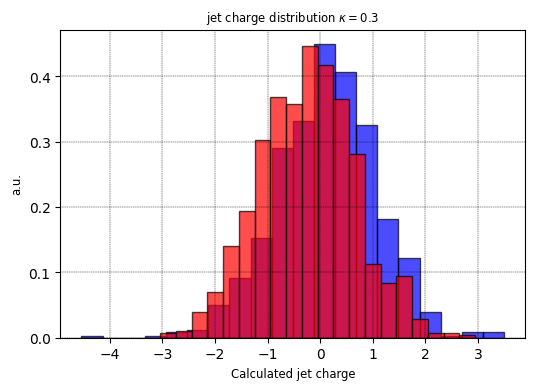

In [646]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_wpT, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_wpTbar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet charge distribution $\kappa=0.3$', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

'''
#Calculating the Gaussian PDF values given Gaussian parameters and random variable X
def gaus(X,C,X_mean,sigma):
    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

mean = sum(hist[1]*hist[0])/sum(hist[0])                  
sigma = sum(hist[0]*(hist[1]-mean)**2)/sum(hist[0]) 
param_optimised,param_covariance_matrix = curve_fit(gaus,hist[1],hist[0],p0=[max(hist[0]),mean,sigma],maxfev=5000)
'''

Text(0, 0.5, 'a.u.')

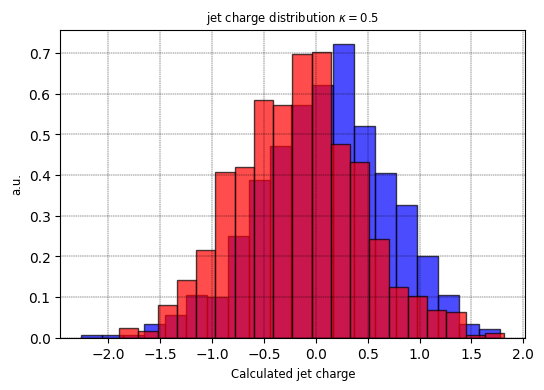

In [642]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_wpT, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_wpTbar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet charge distribution $\kappa=0.5$', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

Text(0, 0.5, 'a.u.')

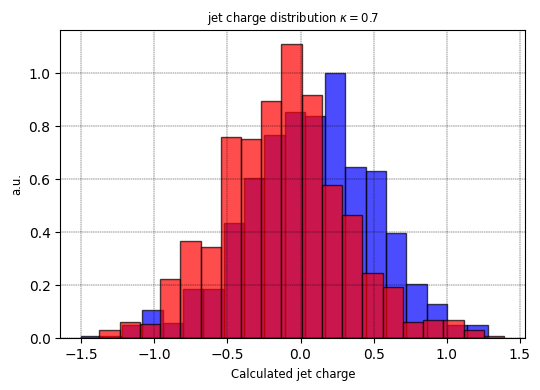

In [639]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_wpT, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_wpTbar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet charge distribution $\kappa=0.7$', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')
#plt.xlim([-3, 3])

Text(0, 0.5, 'a.u.')

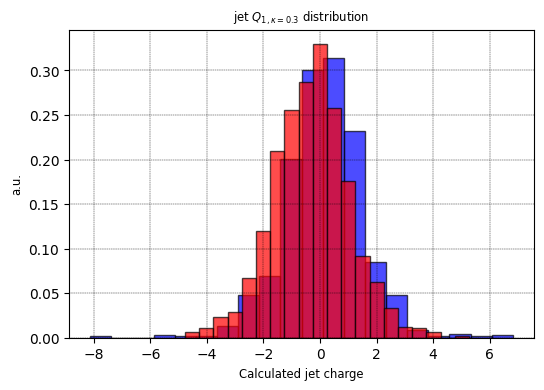

In [35]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_Q_1kappa, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_Q_1kappa_bar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet $Q_{1,\kappa=0.3}$ distribution', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

Text(0, 0.5, 'a.u.')

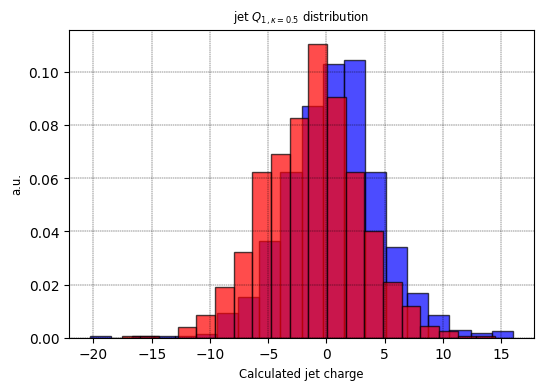

In [643]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_Q_1kappa, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_Q_1kappa_bar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet $Q_{1,\kappa=0.5}$ distribution', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

Text(0, 0.5, 'a.u.')

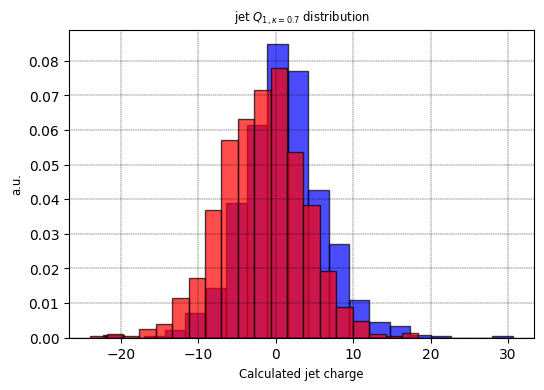

In [638]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_Q_1kappa, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_Q_1kappa_bar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet $Q_{1,\kappa=0.7}$ distribution', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

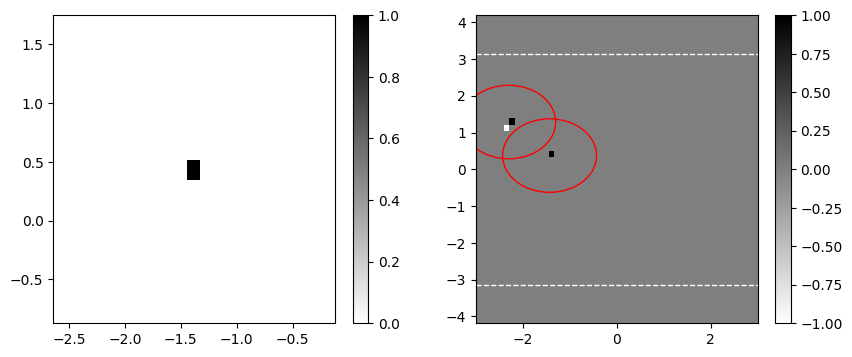

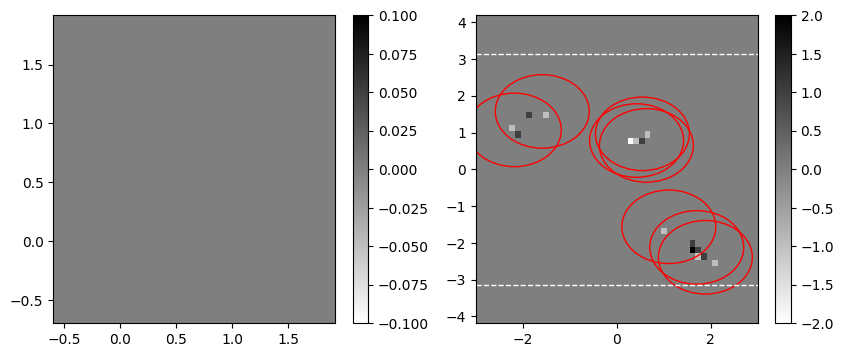

In [ ]:
lhe_file_name = './ug_unweighted_events.lhe.gz'
leading_jet_images, all_jet_images, jetpep, njet = run_pythia_get_images(lhe_file_name, nevents=5*10**3, plot_first_few=True)

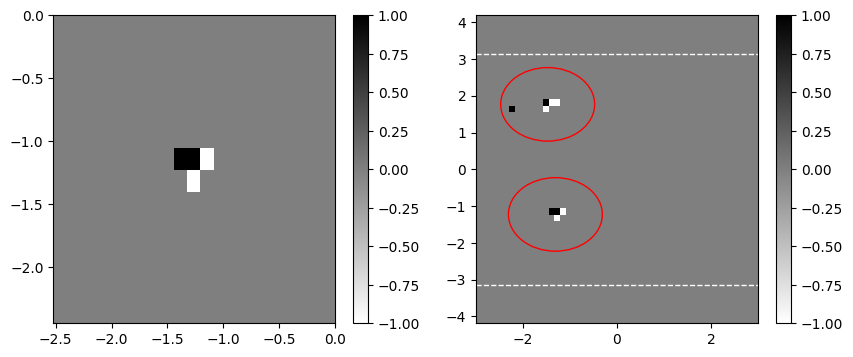

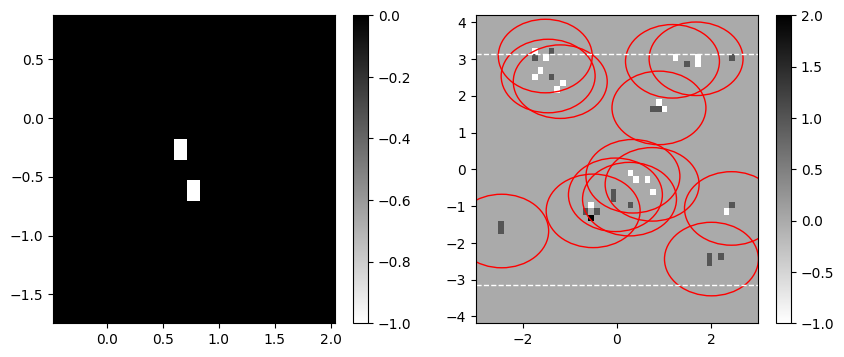

In [ ]:
lhe_file_name = './ubarg_unweighted_events.lhe.gz'
leading_jet_images_bar, all_jet_images_bar, jetpep_bar, njet_bar = run_pythia_get_images(lhe_file_name, nevents=5*10**3, plot_first_few=True)

In [ ]:
#print(all_jet_images[0])
print(len(njet))
print(type(leading_jet_images))
print(type(all_jet_images))
print(type(jetpep))
print(len(leading_jet_images))
print(leading_jet_images[0].shape)
print(all_jet_images[0][0].shape)

4428
<class 'list'>
<class 'list'>
<class 'list'>
4428
(15, 21)
(48, 50)


In [ ]:
import pickle

# Save to a binary file
save_to_file = False
if save_to_file:
    with open(outdir+'up_leading_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images, file)
    with open(outdir+'up_all_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images, file)
    with open(outdir+'up_jetpep_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images, file)        

    with open(outdir+'upbar_leading_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images_bar, file)
    with open(outdir+'upbar_all_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images_bar, file)
    with open(outdir+'upbar_jetpep_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images_bar, file)  

## np.Hist2D (for test)

In [ ]:
print(phiedges.shape)
print(etaedges.shape)

(49,)
(51,)


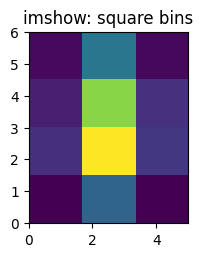

In [ ]:
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt

xedges = [0, 1, 3, 5]
yedges = [0, 2, 3, 4, 6]
#x = np.random.normal(mu=2, sigma=1, size=100)
x = np.random.normal(2, 1, 2000)
y = np.random.normal(3, 1, 2000)
weights = np.random.normal(1, 1, 2000)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), weights=weights)
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [ ]:
print(H)
print(H.shape)
print(type(H))

[[ 35.95733433 190.17393659  34.5208922 ]
 [ 99.1586241  516.25109696 112.68437128]
 [ 76.67369562 430.82547259 102.81178273]
 [ 47.5011651  224.41473281  45.3618157 ]]
(4, 3)
<class 'numpy.ndarray'>


In [ ]:
print(H.shape)
K = pad_image(H)
print(K.shape)

(4, 3)
(16, 22)


In [ ]:
a = [1, 2, 3, 4, 5]
print(np.pad(a, (2, 3), 'constant', constant_values=(4, 6)))
print(np.pad(a, (2, 3), 'constant'))

[4 4 1 2 3 4 5 6 6 6]
[0 0 1 2 3 4 5 0 0 0]


In [ ]:
H + 1

array([[ 36.95733433, 191.17393659,  35.5208922 ],
       [100.1586241 , 517.25109696, 113.68437128],
       [ 77.67369562, 431.82547259, 103.81178273],
       [ 48.5011651 , 225.41473281,  46.3618157 ]])

In [ ]:
print(sum(H))
print(sum(sum(H)))

[ 259.29081914 1361.66523895  295.37886192]
1916.334920009921


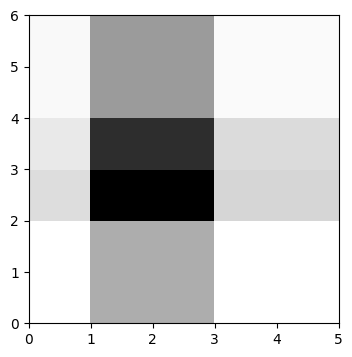

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(4,4))
ax1.pcolor(xedges, yedges, H, cmap=cmap)

## plot some jets

In [ ]:
load_file = False
if load_file:
    leading_jet_images = np.load(outdir+'tt_leading_jet.npz', allow_pickle=True)['arr_0']
    all_jet_images = np.load(outdir+'tt_all_jets.npz', allow_pickle=True)['arr_0']
    jetpep = np.load(outdir+'tt_jetpep.npz', allow_pickle=True)['arr_0']

    leading_jet_images0 = np.load(outdir+'qcd_leading_jet.npz', allow_pickle=True)['arr_0']
    all_jet_images0 = np.load(outdir+'qcd_all_jets.npz', allow_pickle=True)['arr_0']
    jetpep0 = np.load(outdir+'qcd_jetpep.npz', allow_pickle=True)['arr_0']

Pad leading jet images so they all have the same pixels.

In [ ]:
std_jet_images = list(map(pad_image, leading_jet_images))
std_jet_images_bar = list(map(pad_image, leading_jet_images_bar))

In [ ]:
print(len(leading_jet_images))
print(leading_jet_images[0].shape)
print(len(std_jet_images))
print(std_jet_images[0].shape)
#print(std_jet_images[0])
#print(leading_jet_images[0])

4428
(15, 21)
4428
(16, 22)


Plot a few events, first only the leading jet and then the whole event

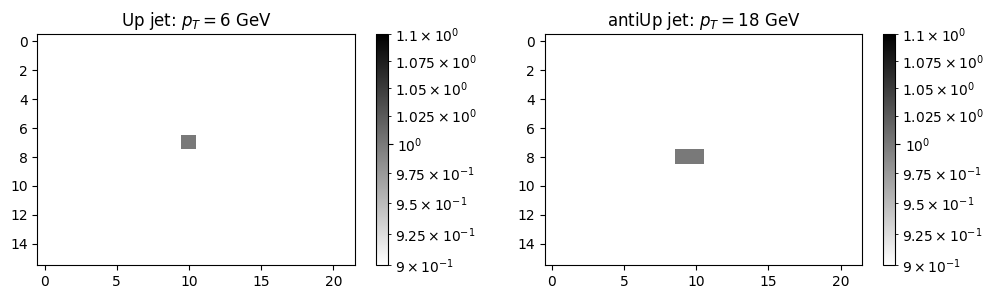

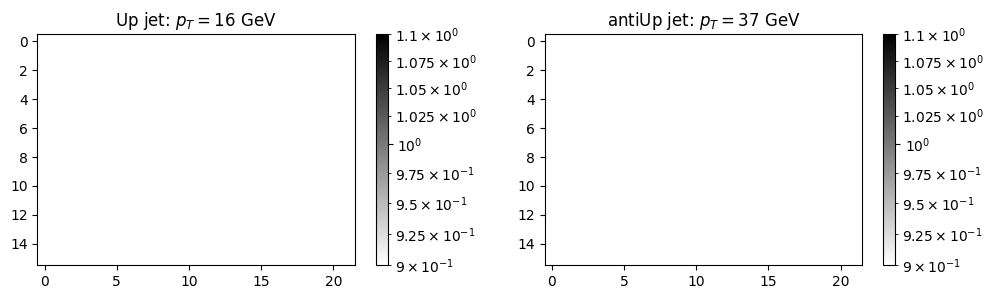

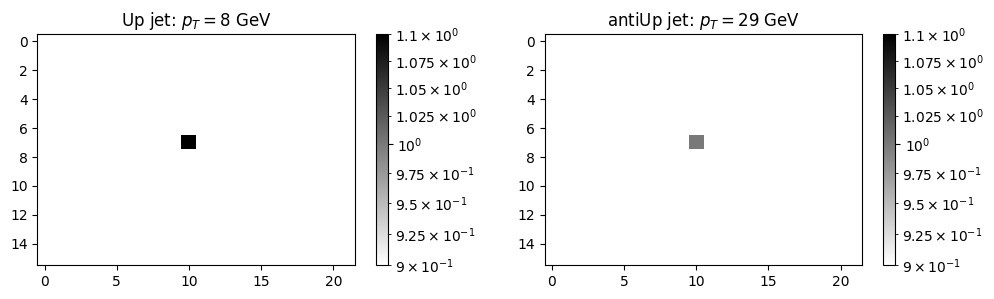

In [ ]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(3):
    fig, (axes1, axes2) = plt.subplots(1,2, figsize=(12,3))    
    im1 = axes1.imshow(std_jet_images[idx], cmap=cmap, **logscale)
    plt.colorbar(im1, ax=axes1)
    axes1.set(title='{} jet: $p_T=${:.0f} GeV'.format('Up', jetpep[idx][0][0]))
    im2 = axes2.imshow(std_jet_images_bar[idx], cmap=cmap, **logscale)
    plt.colorbar(im2, ax=axes2)
    axes2.set(title='{} jet: $p_T=${:.0f} GeV'.format('antiUp', jetpep_bar[idx][0][0]))      

Normalizing the histogram values in 0-255 range: only differences are seen if I use log scale, in which case a bunch of soft energy deposits disappear. The classifier should not care about smaller changes (do not fit the noise!)

In [ ]:
histo = np.array([1,2,3,50,60,100])
(histo/np.max(histo)*255).astype(int)

array([  2,   5,   7, 127, 153, 255])

In [ ]:
np.max(std_jet_images[0])
def normalize(histo, multi=255):

    return (histo/np.max(histo)*multi).astype(int) if np.max(histo)!=0 else histo
norm_jet_images_bar = list(map(normalize, std_jet_images_bar))

In [ ]:
#all_jet_images = list(map(normalize, all_jet_images))
norm_jet_images = list(map(normalize, std_jet_images))

#all_jet_images_bar = list(map(normalize, all_jet_images_bar))
norm_jet_images_bar = list(map(normalize, std_jet_images_bar))

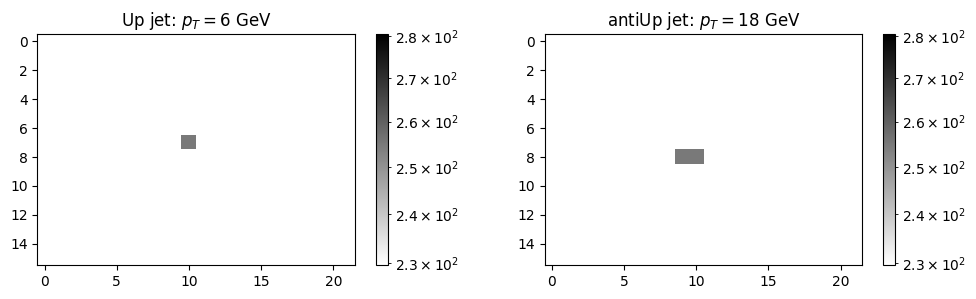

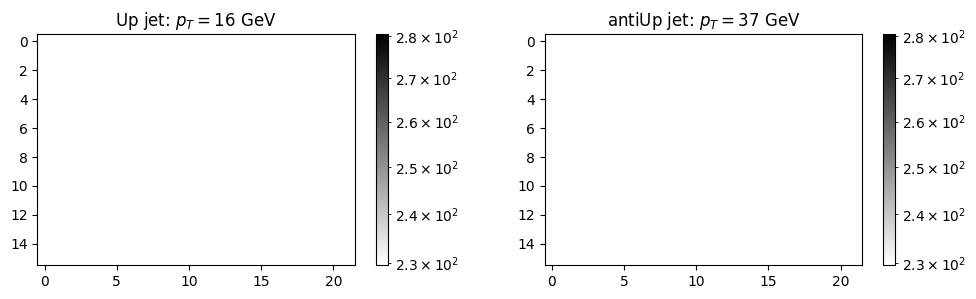

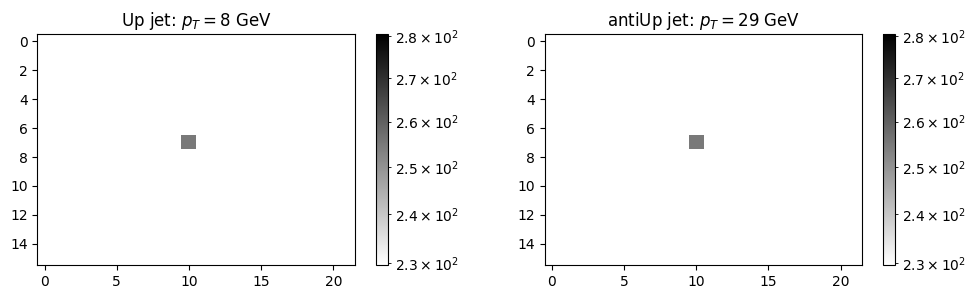

In [ ]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(3):
    fig, axes = plt.subplots(1,2, figsize=(12,3))    
    for iax, ax in enumerate(axes):
        im = ax.imshow([norm_jet_images, norm_jet_images_bar][iax][idx], cmap=cmap, **logscale)
        plt.colorbar(im, ax=ax)

        ax.set(title='{} jet: $p_T=${:.0f} GeV'.format(['Up','antiUp'][iax], [jetpep,jetpep_bar][iax][idx][0][0]))

### More plots

Plotting whole events in the $\eta-\phi$ plane. Also draw a circle around each jet, with opacity set by jet pT

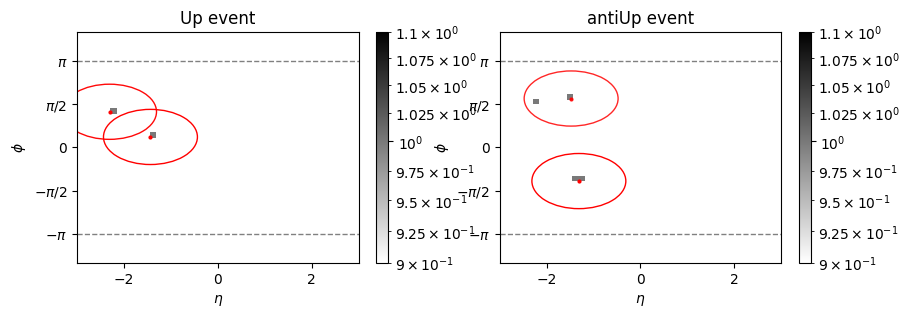

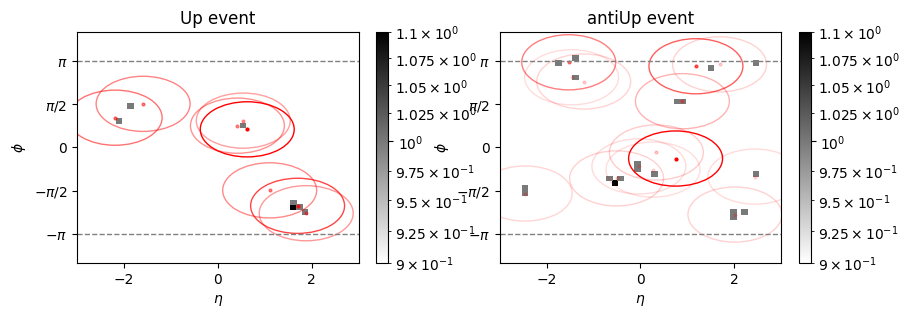

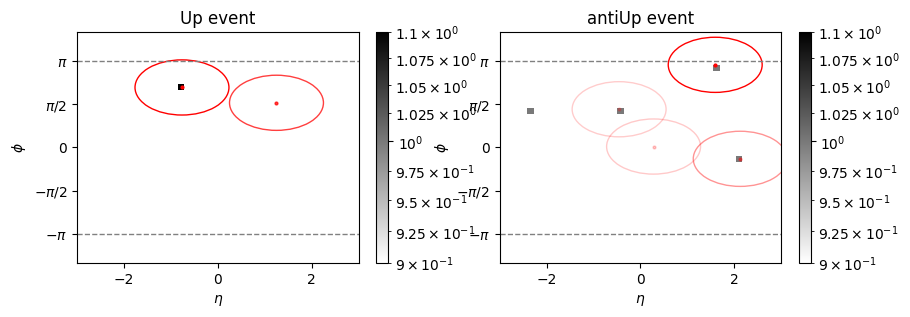

In [ ]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(3):
    fig, axes = plt.subplots(1,2, figsize=(10,3))    
    for iax, ax in enumerate(axes):
        im = ax.pcolor(etaedges, phiedges, sum([all_jet_images, all_jet_images_bar][iax][idx]), cmap=cmap, **logscale)
        plt.colorbar(im, ax=ax)
        jets = [jetpep[idx], jetpep_bar[idx]][iax]
        for j in jets:
            ax.add_artist(plt.Circle((j[1],j[2]),1, color='r', fill=False, alpha=j[0]/max([jj[0] for jj in jets])))
            ax.scatter(j[1],j[2], s=4, c='r', alpha=j[0]/max([jj[0] for jj in jets]))
        ax.set(title='{} event'.format(['Up','antiUp'][iax]), xlabel='$\eta$', ylabel='$\phi$', yticks=np.linspace(-np.pi, np.pi,5), 
               yticklabels=['$-\pi$','$-\pi/2$',0,'$\pi/2$','$\pi$'])
        for h in [-np.pi, np.pi]: 
            ax.axhline(h, ls='--', lw=1, c='gray')

Compare average images:

In [ ]:
list1 = [[1,2,3,4], [1,2,3,4]]
np.average(list1, axis=0)

array([1., 2., 3., 4.])

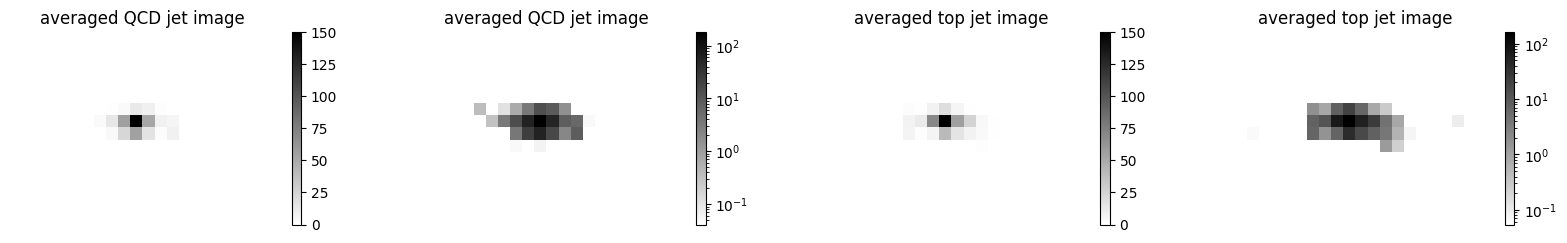

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(20,2.5))
ims = [0]*len(axes)
ims[0]=axes[0].imshow(np.average(std_jet_images_bar, axis=0), vmin=0, vmax=150,cmap=cmap)
ims[1]=axes[1].imshow(np.average(std_jet_images_bar, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)
ims[2]=axes[2].imshow(np.average(std_jet_images, axis=0), vmin=0, vmax=150,cmap=cmap)
ims[3]=axes[3].imshow(np.average(std_jet_images, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set_axis_off(); 
    ax.set(title='averaged {} jet image'.format(['QCD','top'][iax//2]))

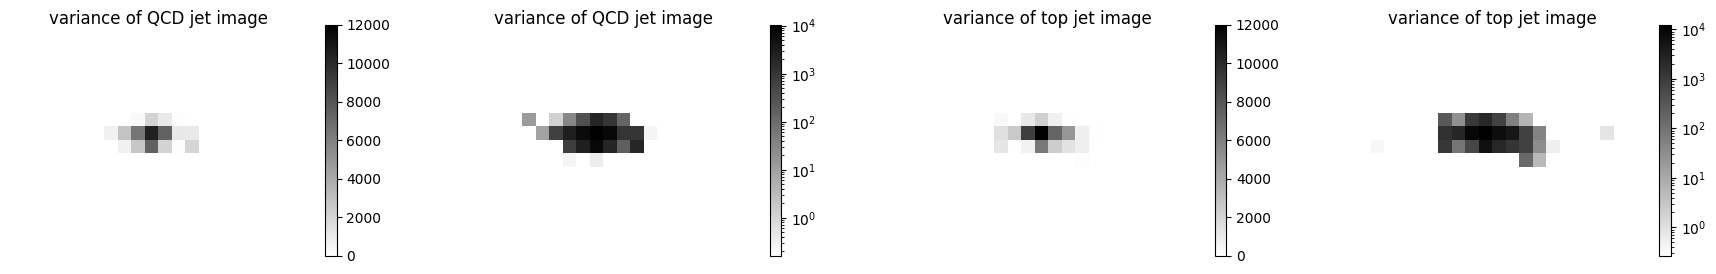

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(22,3))
ims = [0]*len(axes)
ims[0]=axes[0].imshow(np.var(std_jet_images_bar, axis=0), vmax=12000,cmap=cmap)
ims[1]=axes[1].imshow(np.var(std_jet_images_bar, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)
ims[2]=axes[2].imshow(np.var(std_jet_images, axis=0), vmax=12000,cmap=cmap)
ims[3]=axes[3].imshow(np.var(std_jet_images, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set_axis_off(); 
    ax.set(title='variance of {} jet image'.format(['QCD','top'][iax//2]))

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,3))
ims = [0]*len(axes)
ims[0]=axes[0].pcolor(etaedges, phiedges, np.average(map(sum,all_jet_images_bar), axis=0), vmax=1.2,cmap=cmap)
ims[1]=axes[1].pcolor(etaedges, phiedges, np.average(map(sum,all_jet_images), axis=0), vmax=1.2,cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set(xlabel='$\eta$',ylabel='$\phi$') 
    ax.set(title='averaged {} calorimeter image'.format(['QCD','ttbar'][iax]))

# Training neural networks

We will here train the neural networks for classifying between QCD jets and top quark jets. The trainig itself was done on a [Colab notebook](https://colab.research.google.com/) with TPU support to train the networks faster than on my laptop.

## run on Colab

In [ ]:
print(std_jet_images_bar[0].shape)
print(std_jet_images[0].shape)
test = np.array([1,2,3,4])
index = np.random.permutation(len(test))
test[index]

(16, 22)
(16, 22)


array([2, 3, 4, 1])

In [ ]:
indices

array([6217, 8126, 4710, ..., 4859, 3264, 2732])

In [ ]:
y_data_shuffled[0:20]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
import keras
#data0 = np.load(outdir+'qcd_leading_jet.npz', allow_pickle=True)['arr_0']
#data1 = np.load(outdir+'tt_leading_jet.npz', allow_pickle=True)['arr_0']
data0 = std_jet_images
data1 = std_jet_images_bar

print('We have {} Up jets and {} anti-Up jets'.format(len(data0), len(data1)))
x_data = np.concatenate((data0, data1))

y_data = np.array([0]*len(data0)+[1]*len(data1))

np.random.seed(0) # for reproducibility
# Ensure the same permutation is applied to both arrays
indices = np.random.permutation(len(x_data))

# Apply the permutation to both arrays
x_data_shuffled = x_data[indices]
y_data_shuffled = y_data[indices]

# the data coming out of previous commands is a list of 2D arrays. We want a 3D np array (n_events, xpixels, ypixels)
x_data_shuffled = np.stack(x_data_shuffled)

print('before:', x_data_shuffled.shape, y_data_shuffled.shape)

# reshape for tensorflow: x_data.shape + (1,) = shortcut for (x_data.shape[0], 16, 22, 1)
x_data_shuffled = x_data_shuffled.reshape(x_data_shuffled.shape + (1,)).astype('float32')
x_data_shuffled /= 255.

y_data_shuffled = keras.utils.to_categorical(y_data_shuffled, 2)

print('after:', x_data_shuffled.shape, y_data_shuffled.shape)

n_train = 6000
(x_train, x_test) = x_data_shuffled[:n_train], x_data_shuffled[n_train:]
(y_train, y_test) = y_data_shuffled[:n_train], y_data_shuffled[n_train:]

print('We will train+validate on {0} images ({1:.2f}%), leaving {2} iamges ({3:.2f}) for cross-validation'\
      .format(n_train,n_train/len(x_data),len(x_data)-n_train, (len(x_data)-n_train)/len(x_data)))

We have 4428 Up jets and 4757 anti-Up jets
before: (9185, 16, 22) (9185,)
after: (9185, 16, 22, 1) (9185, 2)
We will train+validate on 6000 images (0.65%), leaving 3185 iamges (0.35) for cross-validation


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

### Logostic model

In [ ]:
%%time
model0 = Sequential()
model0.add(Flatten(input_shape=(16, 22, 1)))  # Images are a 3D matrix, we have to flatten them to be 1D
model0.add(Dense(2, kernel_initializer='normal', activation='softmax'))

# Compile model
model0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_logi = model0.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=100, shuffle=True, verbose=0)

CPU times: user 4.93 s, sys: 505 ms, total: 5.43 s
Wall time: 4.82 s


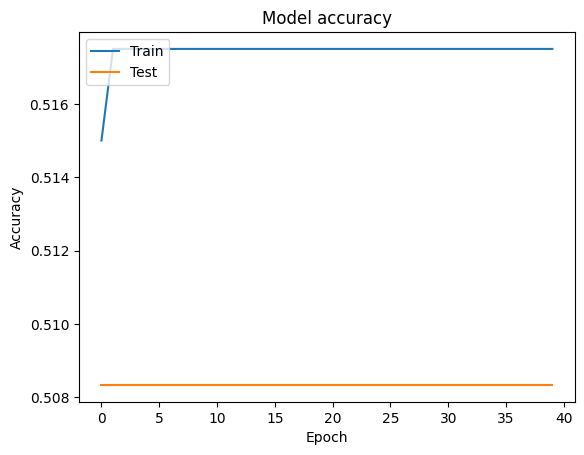

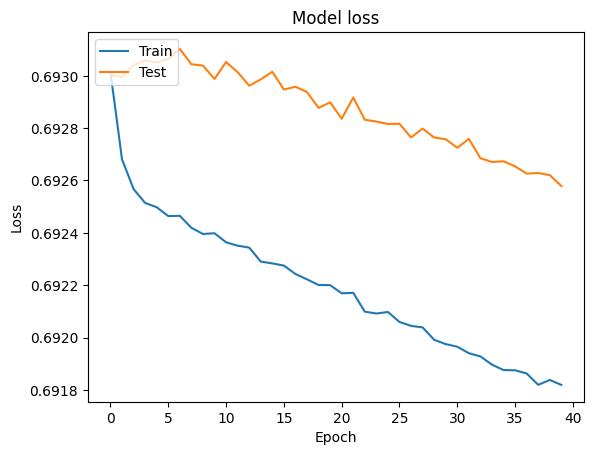

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_logi.history['accuracy'])
plt.plot(history_logi.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_logi.history['loss'])
plt.plot(history_logi.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Simple MLP model

In [ ]:
%%time
model1 = Sequential()
model1.add(Flatten(input_shape=(16, 22, 1)))  # Images are a 3D matrix, we have to flatten them to be 1D
model1.add(Dense(100, kernel_initializer='normal', activation='tanh'))
model1.add(Dropout(0.5)) # drop a unit with  50% probability.

model1.add(Dense(100, kernel_initializer='orthogonal',activation='tanh'))
model1.add(Dropout(0.5)) # drop a unit with  50% probability.

model1.add(Dense(100, kernel_initializer='orthogonal',activation='tanh'))
# model.add(Activation('sigmoid'))
model1.add(Dense(2, kernel_initializer='normal', activation='softmax')) # last layer, this has a softmax to do the classification

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_mlp = model1.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=100, shuffle=True, verbose=1)

Epoch 1/40
48/48 [==============================] - 1s 10ms/step - loss: 0.6930 - accuracy: 0.5088 - val_loss: 0.6933 - val_accuracy: 0.5083
Epoch 2/40
48/48 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.5167 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 3/40
48/48 [==============================] - 0s 8ms/step - loss: 0.6927 - accuracy: 0.5129 - val_loss: 0.6935 - val_accuracy: 0.5083
Epoch 4/40
48/48 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5215 - val_loss: 0.6931 - val_accuracy: 0.4917
Epoch 5/40
48/48 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5108 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 6/40
48/48 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5152 - val_loss: 0.6932 - val_accuracy: 0.5083
Epoch 7/40
48/48 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5175 - val_loss: 0.6932 - val_accuracy: 0.5083
Epoch 8/40
48/48 [=

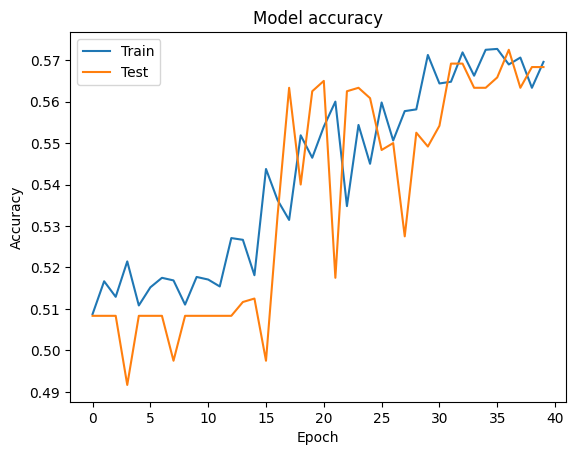

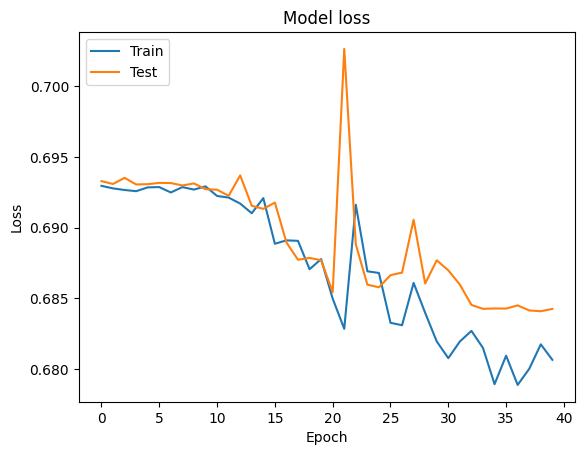

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_mlp.history['accuracy'])
plt.plot(history_mlp.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### CNN model

In [ ]:
%%time
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), input_shape=(16, 22, 1), activation='relu'))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
model_cnn.add(Dense(300, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(2, activation='softmax'))

# Compile model
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn = model_cnn.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=100, shuffle=True, verbose=1)

Epoch 1/40
48/48 [==============================] - 4s 62ms/step - loss: 0.6927 - accuracy: 0.5160 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 2/40
48/48 [==============================] - 3s 59ms/step - loss: 0.6929 - accuracy: 0.5175 - val_loss: 0.6930 - val_accuracy: 0.5083
Epoch 3/40
48/48 [==============================] - 3s 61ms/step - loss: 0.6929 - accuracy: 0.5181 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 4/40
48/48 [==============================] - 3s 62ms/step - loss: 0.6925 - accuracy: 0.5175 - val_loss: 0.6932 - val_accuracy: 0.5083
Epoch 5/40
48/48 [==============================] - 3s 68ms/step - loss: 0.6929 - accuracy: 0.5175 - val_loss: 0.6932 - val_accuracy: 0.5083
Epoch 6/40
48/48 [==============================] - 3s 66ms/step - loss: 0.6926 - accuracy: 0.5175 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 7/40
48/48 [==============================] - 3s 62ms/step - loss: 0.6927 - accuracy: 0.5177 - val_loss: 0.6932 - val_accuracy: 0.5083
Epoch 8/40
48

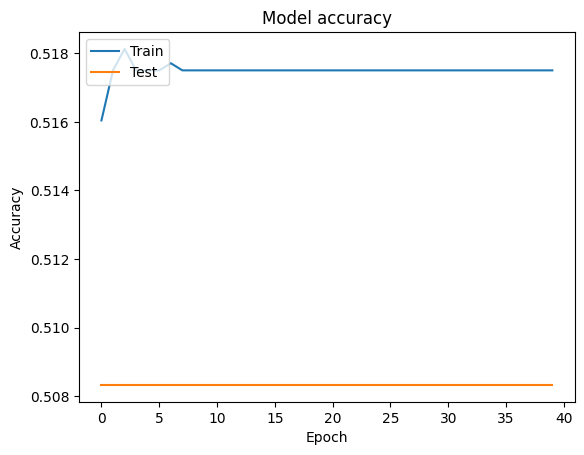

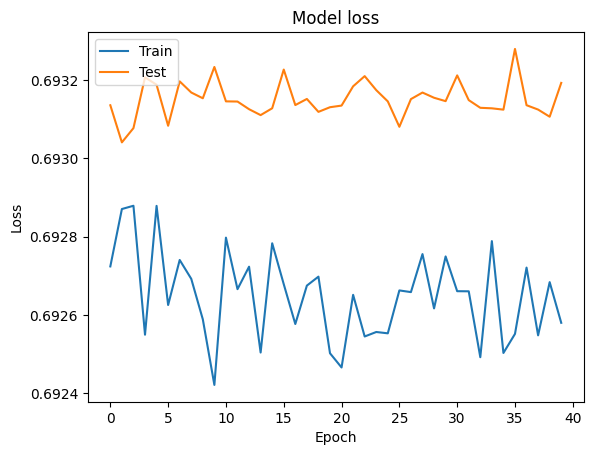

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Save NN models and training histories:

In [ ]:
model_dir='trained_models_low_pt/'
if not os.path.isdir(model_dir): os.system('mkdir '+model_dir)
model0.save(model_dir+'logi.h5')
model1.save(model_dir+'mlp.h5')
model_cnn.save(model_dir+'cnn.h5')
np.savez(model_dir+'training_histories.npz', [ history.history for history in [history_logi, history_mlp, history_cnn ]])


## analyze (for ttbar anc QCD discrimination and not charge)

Download the trained models from Colab, load them and analyze training/ROC curves (mkae sure you have loaded and reshaped the train/test datasets above)

In [ ]:
model_dir='trained_models_low_pt/'

history_logi, history_mlp, history_cnn = np.load(model_dir+'training_histories.npz', allow_pickle=True)['arr_0']
model0 = keras.models.load_model(model_dir+'logi.h5')
model1 = keras.models.load_model(model_dir+'mlp.h5')
model_cnn = keras.models.load_model(model_dir+'cnn.h5')

In [ ]:
predictions0 = model0.predict(x_test)
predictions1 = model1.predict(x_test)
predictions_cnn = model_cnn.predict(x_test)

693/693 [==============================] - 3s 4ms/step


In [ ]:
history_logi.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

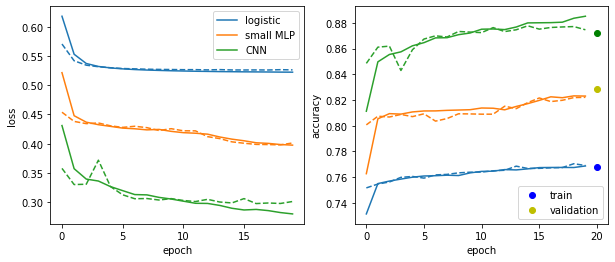

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

nn=20
axes[1].scatter(nn, 1.*sum(np.argmax(predictions0, axis=1) == np.argmax(y_test, axis=1))/ len(y_test),c='b')
axes[1].scatter(nn, 1.*sum(np.argmax(predictions1, axis=1) == np.argmax(y_test, axis=1))/ len(y_test),c='y')
axes[1].scatter(nn, 1.*sum(np.argmax(predictions_cnn, axis=1) == np.argmax(y_test, axis=1))/ len(y_test),c='g')
for i, history in enumerate([history_logi, history_mlp, history_cnn]):
    axes[1].plot(history['accuracy'][:nn], c=plt.get_cmap("tab10")(i), label='train')
    axes[1].plot(history['val_accuracy'][:nn], c=plt.get_cmap("tab10")(i), ls ='--', label='validation')
    axes[0].plot(history['loss'][:nn], c=plt.get_cmap("tab10")(i), label=['logistic','small MLP', 'CNN', 'CNN v2'][i])
    axes[0].plot(history['val_loss'][:nn], c=plt.get_cmap("tab10")(i), ls='--')
for iax in range(2):
    axes[iax].set(xlabel='epoch', ylabel=['loss','accuracy'][iax])
axes[0].legend()
axes[1].legend(['train','validation']);
fig.savefig('training_history.png')

In [ ]:
from sklearn.metrics import roc_curve
fpr0, tpr0, thresholds = roc_curve(y_test.ravel(), predictions0.ravel())
fpr1, tpr1, thresholds = roc_curve(y_test.ravel(), predictions1.ravel())
fpr_cnn, tpr_cnn, thresholds = roc_curve(y_test.ravel(), predictions_cnn.ravel())

from sklearn.metrics import auc
auc0 = auc(fpr0, tpr0)
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr_cnn, tpr_cnn)

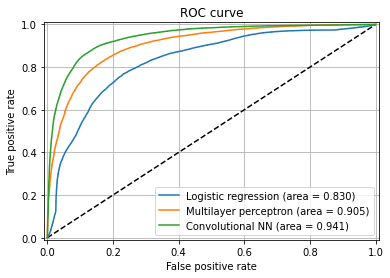

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr0, tpr0, label='Logistic regression (area = {:.3f})'.format(auc0))
plt.plot(fpr1, tpr1, label='Multilayer perceptron (area = {:.3f})'.format(auc1))
plt.plot(fpr_cnn, tpr_cnn, label='Convolutional NN (area = {:.3f})'.format(auc2))
plt.gca().set(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve', xlim=(-0.01,1.01), ylim=(-0.01,1.01))
plt.grid(True, which="both")
plt.legend(loc='lower right');
plt.savefig('ROC_curve.png')

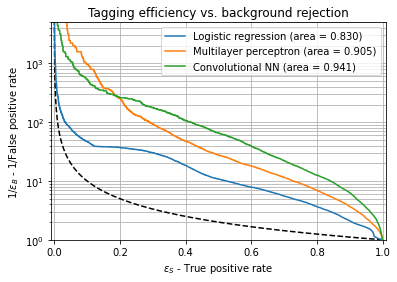

In [ ]:
np.seterr(divide='ignore', invalid='ignore') # disable warning for 1/0 divisions
plt.plot(thresholds, 1/thresholds, 'k--')
plt.plot(tpr0, 1/fpr0, label='Logistic regression (area = {:.3f})'.format(auc0))
plt.plot(tpr1, 1/fpr1, label='Multilayer perceptron (area = {:.3f})'.format(auc1))
plt.plot(tpr_cnn, 1/fpr_cnn, label='Convolutional NN (area = {:.3f})'.format(auc2))
plt.gca().set(ylabel='1/$\epsilon_B$ - 1/False positive rate', xlabel='$\epsilon_S$ - True positive rate', title='Tagging efficiency vs. background rejection', xlim=(-0.01,1.01), ylim=(1,5*10**3), yscale='log')
plt.grid(True, which="both")
plt.legend(loc='upper right');
plt.savefig('ROC_curve_bg_rej.png')

Check most certain and most uncertain NN predictions. Also check when the NN is most certain of its failed predictions

In [ ]:
predictions_cnn.argmax(axis=0)

array([  832, 12992])

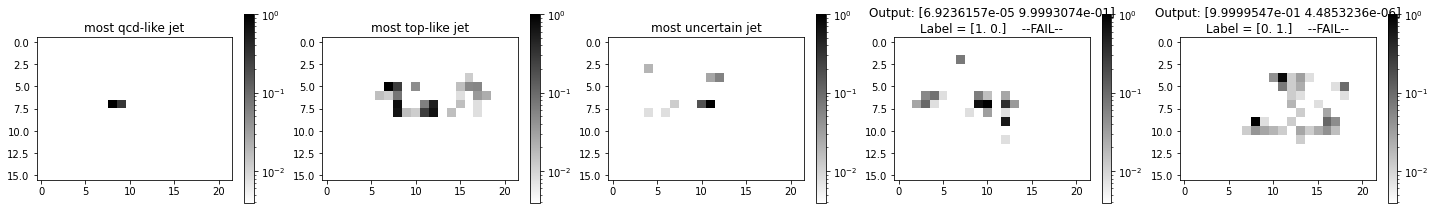

In [ ]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

fig, axes = plt.subplots(1,5,figsize=(20,3))
for i in range(2):
    im = axes[i].imshow(x_test[predictions_cnn.argmax(axis=0)[i],:,:,0], cmap=cmap, **logscale)
    plt.colorbar(im, ax=axes[i])
    axes[i].set(title='most {}-like jet'.format(['qcd','top'][i]))
  
axes[2].imshow(x_test[abs(predictions_cnn-0.5).argmin(axis=0)[0],:,:,0], cmap=cmap, **logscale)
plt.colorbar(im, ax=axes[2])
axes[2].set(title='most uncertain jet');

for iax, i in enumerate((predictions_cnn - y_test).argmin(axis=0)):
    im = axes[iax+3].imshow(x_test[i,:,:,0], cmap=cmap, **logscale)
    plt.colorbar(im, ax=axes[iax+3])
    axes[iax+3].set_title('Output: {}\nLabel = {}    --FAIL--'.format(predictions_cnn[i], y_test[i]))

fig.tight_layout()
fig.savefig('cnn_jet_sample.png', dpi=150)

What does the model think of an empty image?

In [ ]:
empty = np.zeros(x_test[0].shape)
[model.predict(np.array([empty])) for model in [model0, model1, model_cnn]]

[array([[0.7229311 , 0.27706897]], dtype=float32),
 array([[0.6891926 , 0.31080747]], dtype=float32),
 array([[0.9867889, 0.013211 ]], dtype=float32)]

Not great! Looks a lot like a QCD jet! Because the only difference from a sharp QCD jet is in one or a few pixels! Bad CNN! 

In real world applications, one would need to make sure they are passing images with at least one hot pixel. For example, see the image brightness:

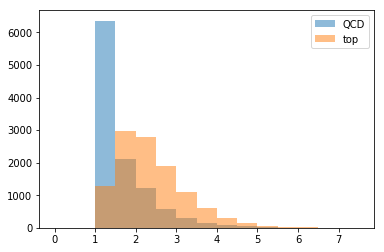

In [ ]:
plt.hist(map(np.sum, [ x for x,y in zip(x_test, y_test)[:] if np.argmax(y)==0] ), bins=np.arange(0,8,0.5), alpha=0.5, label='QCD')
plt.hist(map(np.sum, [ x for x,y in zip(x_test, y_test)[:] if np.argmax(y)==1] ), bins=np.arange(0,8,0.5), alpha=0.5, label='top')
plt.legend();